# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

3.7.4


# Przygotowanie odpowiednich danych

In [2]:
# Jeśli zajdzie potrzeba
# from google.colab import drive

# drive.mount('/content/drive')

In [3]:
'''
Dla PoC wykonuje obliczenia dla:
 * '../data/DogsCats'
Folder docelowy:
 * '../data/Photos'
 
Wilkość zdjęcia zależna od urzytego rozwiązania:
 * dla CNN będzie to 128(np. dla ResNetu - 224)
'''

dir_path = '../data/DogsCats'
A_folder = 'cats'
B_folder = 'dogs'
image_size = 128 # Wielkość zdjęć Resnetu

# Załadowanie danych

In [4]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random
import os

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


# Stałe

In [5]:
# Wilkości odpowiednie dla ResNetu

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Przygotowanie Danych

In [6]:
'''
Opis danych:
1 - klasa 1 -> Koty
0 - klasa 2 -> Psy
''' 

A_folder_list = os.listdir(dir_path + '/' + A_folder)
B_folder_list = os.listdir(dir_path + '/' + B_folder)

filenames = []
categories = []

for filename in A_folder_list:
    categories.append(1)
    filenames.append(dir_path + '/' + A_folder + '/' + filename)

for filename in B_folder_list:
    categories.append(0)
    filenames.append(dir_path + '/' + B_folder + '/' + filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [7]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df.head()

,filename,category
0,../data/DogsCats/cats/cat.493.jpg,1
1,../data/DogsCats/dogs/dog.9112.jpg,0
2,../data/DogsCats/cats/cat.745.jpg,1
3,../data/DogsCats/dogs/dog.11022.jpg,0
4,../data/DogsCats/dogs/dog.11363.jpg,0


In [9]:
df.shape

(25000, 2)

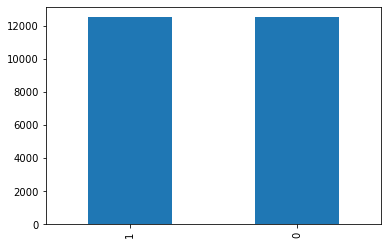

In [10]:
df['category'].value_counts().plot.bar()

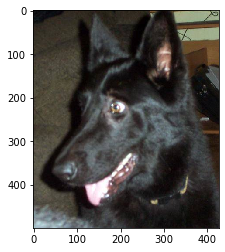

In [11]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)

# Obróbka danych

In [12]:
 '''
Podział danych z całego df na X i y:

X - wszystko oprócz category
y - category
'''

X, y = df.iloc[:, 0:-1], df.iloc[:, -1]

In [13]:
df.head()

,filename,category
0,../data/DogsCats/cats/cat.493.jpg,1
1,../data/DogsCats/dogs/dog.9112.jpg,0
2,../data/DogsCats/cats/cat.745.jpg,1
3,../data/DogsCats/dogs/dog.11022.jpg,0
4,../data/DogsCats/dogs/dog.11363.jpg,0


In [14]:
X.head()

,filename
0,../data/DogsCats/cats/cat.493.jpg
1,../data/DogsCats/dogs/dog.9112.jpg
2,../data/DogsCats/cats/cat.745.jpg
3,../data/DogsCats/dogs/dog.11022.jpg
4,../data/DogsCats/dogs/dog.11363.jpg


In [15]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: category, dtype: int64

In [16]:
# 20% danych do testów
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = odp)
result = next(kf.split(X, y))

'''
Podział danych z całego df na podstawie splitu

train - 80% danych(20000)
test  - 20% danych(5000)
'''
train = df.iloc[result[0]]
test =  df.iloc[result[1]]

# Reset indeksów
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

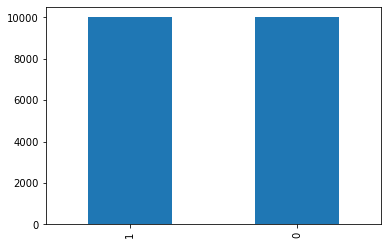

In [17]:
train['category'].value_counts().plot.bar()

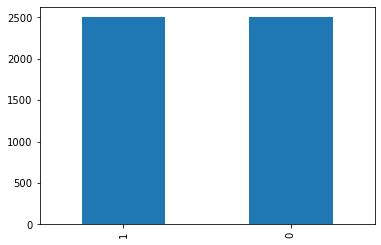

In [18]:
test['category'].value_counts().plot.bar()

In [19]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t train: {train.shape}')
print(f'\t test: {test.shape}')

Kształt danych:
	 df: (25000, 2)
	 train: (20000, 2)
	 test: (5000, 2)


In [20]:
# Upewnienie się że dane w train[filename] i test[filename] są stringiem - lepsze dla generatorów

train['filename'] = train['filename'].astype(str) 
test['filename'] = test['filename'].astype(str)

# Upewnienie się że dane w train[category] i test[category] są stringiem - lepsze dla generatorów

train['category'] = train['category'].astype(str) 
test['category'] = test['category'].astype(str)

In [21]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t train: {train.shape}')
print(f'\t test: {test.shape}')

Kształt danych:
	 df: (25000, 2)
	 train: (20000, 2)
	 test: (5000, 2)


# Funkcję liczące statystyki

In [22]:
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

In [23]:
def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [24]:
'''
Źrodło:
https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
'''

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [25]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=True,
                          show_normed=True,
                          class_names=classes)

In [26]:
'''
cb_early_stopper - skończenie uczenia kiedy val_loss nie będzie się poprawiać przez 10 epok
cb_checkpointer - zapis modelu do pliku 'best.h5' modeli o najlepszym(najmniejszym) val_loss
cb_learning_rate_reduction - zmniejszenie LR jeśli val_loss nie będzie się poprawiać przez 5 epok
'''

EARLY_STOP_PATIENCE = 10
LEARNING_RATE_PATIENCE = 5

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)

# Dobór parametrów

In [27]:
# To Do

batch_size = 50
activation = 'relu'
loss_type = 'categorical_crossentropy'
optimizer = 'Adam'
dropout = 0.25
epochs = 50

# Generatory

In [41]:
'''
Generator dla danych trenningowych
 * losowa rotacja o 15 stopni
 * reskalowanie
 * przybliżenie
 * obrót horyzontalny
 * zakresy dla przesunieć wertykalnych i horyzontalnych
'''

from keras.applications.resnet import preprocess_input

data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = data_gen.flow_from_dataframe(
    dataframe = train,
    x_col = 'filename',
    y_col = 'category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [42]:
'''
Generator dla danych testowych
 * reskalowanie
'''

test_generator = data_gen.flow_from_dataframe( 
    dataframe = test,
    x_col = 'filename',
    y_col = 'category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [45]:
example_df = train.sample(n=1).reset_index(drop=True)

example_generator = data_gen.flow_from_dataframe(
    dataframe = example_df,
    x_col = 'filename',
    y_col = 'category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 1 validated image filenames belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

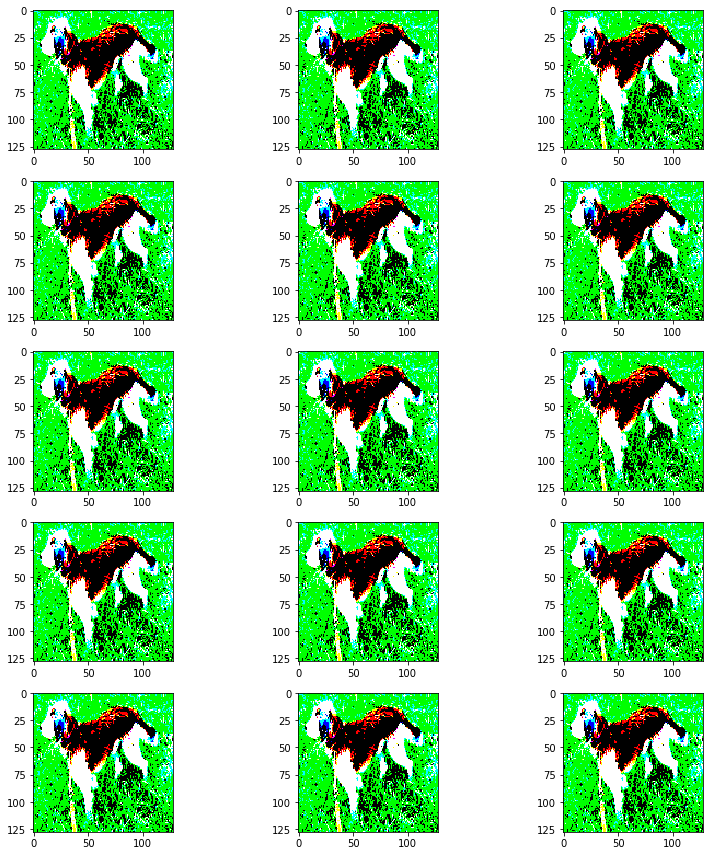

In [46]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Model Fine-Tuning

In [39]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.resnet import ResNet50

pre_trained_model_fn = ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet')

for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

model_fn = Sequential()

model_fn.add(pre_trained_model_fn)
model_fn.add(Dense(256, activation='relu'))
model_fn.add(Dropout(0.25))
model_fn.add(BatchNormalization())
model_fn.add(Dense(2, activation='softmax'))

model_fn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_11 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 514       
Total params: 24,113,794
Trainable params: 24,060,162
Non-trainable params: 53,632
_________________________________________________________________


# ResNet bez żadnych wag wejściowych

In [40]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.resnet import ResNet50

pre_trained_model_v = ResNet50(include_top = True, weights = None)

for layer in pre_trained_model.layers:
    layer.trainable = True

model_v = Sequential()

model_v.add(pre_trained_model_v)
model_v.add(Dense(256, activation='relu'))
model_v.add(Dropout(0.25))
model_v.add(BatchNormalization())
model_v.add(Dense(2, activation='softmax'))

model_v.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
dense_13 (Dense)             (None, 256)               256256    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 514       
Total params: 25,894,506
Trainable params: 25,840,874
Non-trainable params: 53,632
_________________________________________________________________


# Fit

In [ ]:
model_fn.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy', get_f1])

history_fn = model_fn.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = test_generator,
    validation_steps= test.shape[0]//batch_size,
    steps_per_epoch = train.shape[0]//batch_size,
    callbacks = [cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction]
)

# Wczytanie najlepszego
model_fn.load_weights('best_fn.h5')

# Zapis
model_fn.save('the_best_fn.h5')

In [ ]:
model_v.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy', get_f1])

history_v = model_v.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = test_generator,
    validation_steps= test.shape[0]//batch_size,
    steps_per_epoch = train.shape[0]//batch_size,
    callbacks = [cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction]
)

# Wczytanie najlepszego
model_v.load_weights('best_v.h5')

# Zapis
model_v.save('the_best_v.h5')

# Statystyki

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Wykres loss
ax1.plot(history_fn.history['loss'], color='b', label="Training loss")
ax1.plot(history_fn.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(numpy.arange(0, len(history_fn.history['val_loss']), 1))
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

# Wykres accuracy
ax2.plot(history_fn.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_fn.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(numpy.arange(0, len(history_fn.history['val_accuracy']), 1))
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')

# Wykres F1
ax3.plot(history_fn.history['get_f1'], color='b', label="Training f1")
ax3.plot(history_fn.history['val_get_f1'], color='r',label="Validation f1")
ax3.set_xticks(numpy.arange(0, len(history_fn.history['get_f1']), 1))
ax3.legend(loc='best', shadow=True)
ax3.set_ylabel('f1')
ax3.set_xlabel('epoch')


plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Wykres loss
ax1.plot(history_v.history['loss'], color='b', label="Training loss")
ax1.plot(history_v.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(numpy.arange(0, len(history_v.history['val_loss']), 1))
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

# Wykres accuracy
ax2.plot(history_v.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_v.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(numpy.arange(0, len(history_v.history['val_accuracy']), 1))
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')

# Wykres F1
ax3.plot(history_v.history['get_f1'], color='b', label="Training f1")
ax3.plot(history_v.history['val_get_f1'], color='r',label="Validation f1")
ax3.set_xticks(numpy.arange(0, len(history_v.history['get_f1']), 1))
ax3.legend(loc='best', shadow=True)
ax3.set_ylabel('f1')
ax3.set_xlabel('epoch')


plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [ ]:
stats_df = pd.DataFrame({
    'filename': test['filename'],
    'category': test['category'],
    'predict_fn': None,
    'predict_v': None
})

# Mieszamy!
stats_df = stats_df.sample(frac=1).reset_index(drop=True)

stats_df.head()

In [ ]:
validate_generator = data_gen.flow_from_dataframe( 
    dataframe = stats_df,
    x_col = 'filename',
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
predict_fn = model_fn.predict_generator(validate_generator, verbose=True)

predict_v = model_v.predict_generator(validate_generator, verbose=True)

In [ ]:
# Zamiana z one hot encodera na jedno wyjście
stats_df['predict_fn'] = numpy.argmax(predict_fn, axis=-1)
stats_df['predict_v'] = numpy.argmax(predict_v, axis=-1)

In [ ]:
stats_df.head()

In [ ]:
stats_df['predict_fn'].value_counts().plot.bar()

In [ ]:
stats_df['predict_v'].value_counts().plot.bar()

In [ ]:
y_true_fn = stats_df['category'].to_numpy().astype(int)
y_pred_fn = stats_df['predict_fn'].to_numpy().astype(int)

y_true_v = stats_df['category'].to_numpy().astype(int)
y_pred_v = stats_df['predict_v'].to_numpy().astype(int)

In [ ]:
cm_fn = confusion_matrix(y_true_fn, y_pred_fn)
cm_v = confusion_matrix(y_true_v, y_pred_v)

In [ ]:
plot_cm(cm_fn, ['Cats', 'Dogs'])

In [ ]:
print(cm_fn)

In [ ]:
loss, accuracy, get_f1  = model_fn.evaluate_generator(test_generator, verbose=True)

In [ ]:
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
print(f'Test F1: {get_f1:.3}')

In [ ]:
accuracy, precision, recall, fscore = countStats(y_true_fn, y_pred_fn)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')

In [ ]:
plot_cm(cm_v, ['Cats', 'Dogs'])

In [ ]:
print(cm_v)

In [ ]:
accuracy, precision, recall, fscore = countStats(y_true_v, y_pred_v)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')

In [ ]:
loss, accuracy, get_f1  = model_v.evaluate_generator(test_generator, verbose=True)

In [ ]:
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
print(f'Test F1: {get_f1:.3}')